In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import re

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

In [2]:
# Load and Inspect Data
import os
print("Available files:")
print(os.listdir('/kaggle/input/amazon-best-sellers-2025/'))

df = pd.read_csv('/kaggle/input/amazon-best-sellers-2025/Amazon_bestsellers_items_2025.csv')

print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst 5 rows:")
df.head()

Available files:
['Amazon_bestsellers_items_2025.csv']
Dataset Shape: (999, 12)

Columns: ['Unnamed: 0', 'rank', 'asin', 'product_title', 'product_price', 'product_star_rating', 'product_num_ratings', 'product_url', 'product_photo', 'rank_change_label', 'country', 'page']

First 5 rows:


,Unnamed: 0,rank,asin,product_title,product_price,product_star_rating,product_num_ratings,product_url,product_photo,rank_change_label,country,page
0,0,1,B073VKKNN9,Kaspersky | Premium - Total Security (Ultimate...,₹469.00,4.3,13324.0,https://www.amazon.in/dp/B073VKKNN9,https://images-eu.ssl-images-amazon.com/images...,NaN,IN,1
1,1,2,B07PQZJ6Y8,"K7 Security K7, Total Security, 1 User, 1 Year...",₹370.00,4.4,2291.0,https://www.amazon.in/dp/B07PQZJ6Y8,https://images-eu.ssl-images-amazon.com/images...,NaN,IN,1
2,2,3,B0D1KL34JM,Microsoft Office 2021 Professional - Lifetime ...,"₹1,799.00",4.5,388.0,https://www.amazon.in/dp/B0D1KL34JM,https://images-eu.ssl-images-amazon.com/images...,NaN,IN,1
3,3,4,B07B9YYLGG,"Bitdefender - 1 Device,1 Year - Mobile Securit...",₹94.00,4.1,9630.0,https://www.amazon.in/dp/B07B9YYLGG,https://images-eu.ssl-images-amazon.com/images...,NaN,IN,1
4,4,5,B073VLGMZ4,"McAfee Total Protection 2025 | 1 Device, 3 Yea...","₹1,699.00",4.4,5783.0,https://www.amazon.in/dp/B073VLGMZ4,https://images-eu.ssl-images-amazon.com/images...,NaN,IN,1


**Data Quality Assessment**

In [3]:
print("Missing Values:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Percentage': missing_percent.round(2)
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\nData Types:")
print(df.dtypes)

print("\nCountry Distribution:")
print(df['country'].value_counts())

print("\nRating Range:")
print(f"Min Rating: {df['product_star_rating'].min()}")
print(f"Max Rating: {df['product_star_rating'].max()}")
print(f"Mean Rating: {df['product_star_rating'].mean():.2f}")

Missing Values:
                     Missing Count  Percentage
product_price                   54        5.41
product_star_rating             30        3.00
product_num_ratings             30        3.00
rank_change_label              999      100.00

Data Types:
Unnamed: 0               int64
rank                     int64
asin                    object
product_title           object
product_price           object
product_star_rating    float64
product_num_ratings    float64
product_url             object
product_photo           object
rank_change_label      float64
country                 object
page                     int64
dtype: object

Country Distribution:
country
IN    100
CA    100
AU    100
DE    100
FR    100
IT    100
ES    100
JP    100
MX    100
US     99
Name: count, dtype: int64

Rating Range:
Min Rating: 1.0
Max Rating: 5.0
Mean Rating: 4.14


**Data Preprocessing and Feature Engineering**

In [4]:
# Data Preprocessing and Feature Engineering
df_clean = df.copy()

# Remove unnecessary columns
df_clean = df_clean.drop(['Unnamed: 0', 'rank_change_label'], axis=1)

# Extract currency and numeric price
def extract_price_info(price_str):
    if pd.isna(price_str):
        return None, None
    
    currency_map = {'₹': 'INR', '$': 'USD', '€': 'EUR', '£': 'GBP', '¥': 'JPY', 'C$': 'CAD'}
    
    for symbol, code in currency_map.items():
        if symbol in str(price_str):
            numeric_price = re.sub(r'[^\d.]', '', str(price_str))
            try:
                return float(numeric_price), code
            except:
                return None, code
    return None, None

price_info = df_clean['product_price'].apply(extract_price_info)
df_clean['price_numeric'] = price_info.apply(lambda x: x[0] if x else None)
df_clean['currency'] = price_info.apply(lambda x: x[1] if x else None)

# Extract brand from product title
def extract_brand(title):
    if pd.isna(title):
        return 'Other'
    
    brands = ['Kaspersky', 'McAfee', 'Bitdefender', 'Microsoft', 'Norton', 'K7', 'Quick Heal', 'Apple', 'Adobe']
    title_lower = title.lower()
    
    for brand in brands:
        if brand.lower() in title_lower:
            return brand
    return 'Other'

df_clean['brand'] = df_clean['product_title'].apply(extract_brand)

# Categorize products
def categorize_product(title):
    if pd.isna(title):
        return 'Other'
    
    title_lower = title.lower()
    
    if any(word in title_lower for word in ['antivirus', 'security', 'total security']):
        return 'Cybersecurity'
    elif 'office' in title_lower:
        return 'Productivity Suite'
    elif any(word in title_lower for word in ['windows', 'win 11', 'win 10']):
        return 'Operating System'
    elif any(word in title_lower for word in ['app store', 'gift card']):
        return 'Digital Credits'
    else:
        return 'Other Software'

df_clean['category'] = df_clean['product_title'].apply(categorize_product)

print("Data preprocessing completed!")
print(f"New shape: {df_clean.shape}")
print(f"New columns: {list(df_clean.columns[-3:])}")
print("\nBrand distribution:")
print(df_clean['brand'].value_counts())
print("\nCategory distribution:")
print(df_clean['category'].value_counts())

Data preprocessing completed!
New shape: (999, 14)
New columns: ['currency', 'brand', 'category']

Brand distribution:
brand
Other          483
Microsoft      124
Norton          99
Kaspersky       82
McAfee          79
Bitdefender     62
Adobe           38
Quick Heal      17
K7              11
Apple            4
Name: count, dtype: int64

Category distribution:
category
Other Software        436
Cybersecurity         331
Operating System      137
Productivity Suite     93
Digital Credits         2
Name: count, dtype: int64


**Market Analysis Visualization**

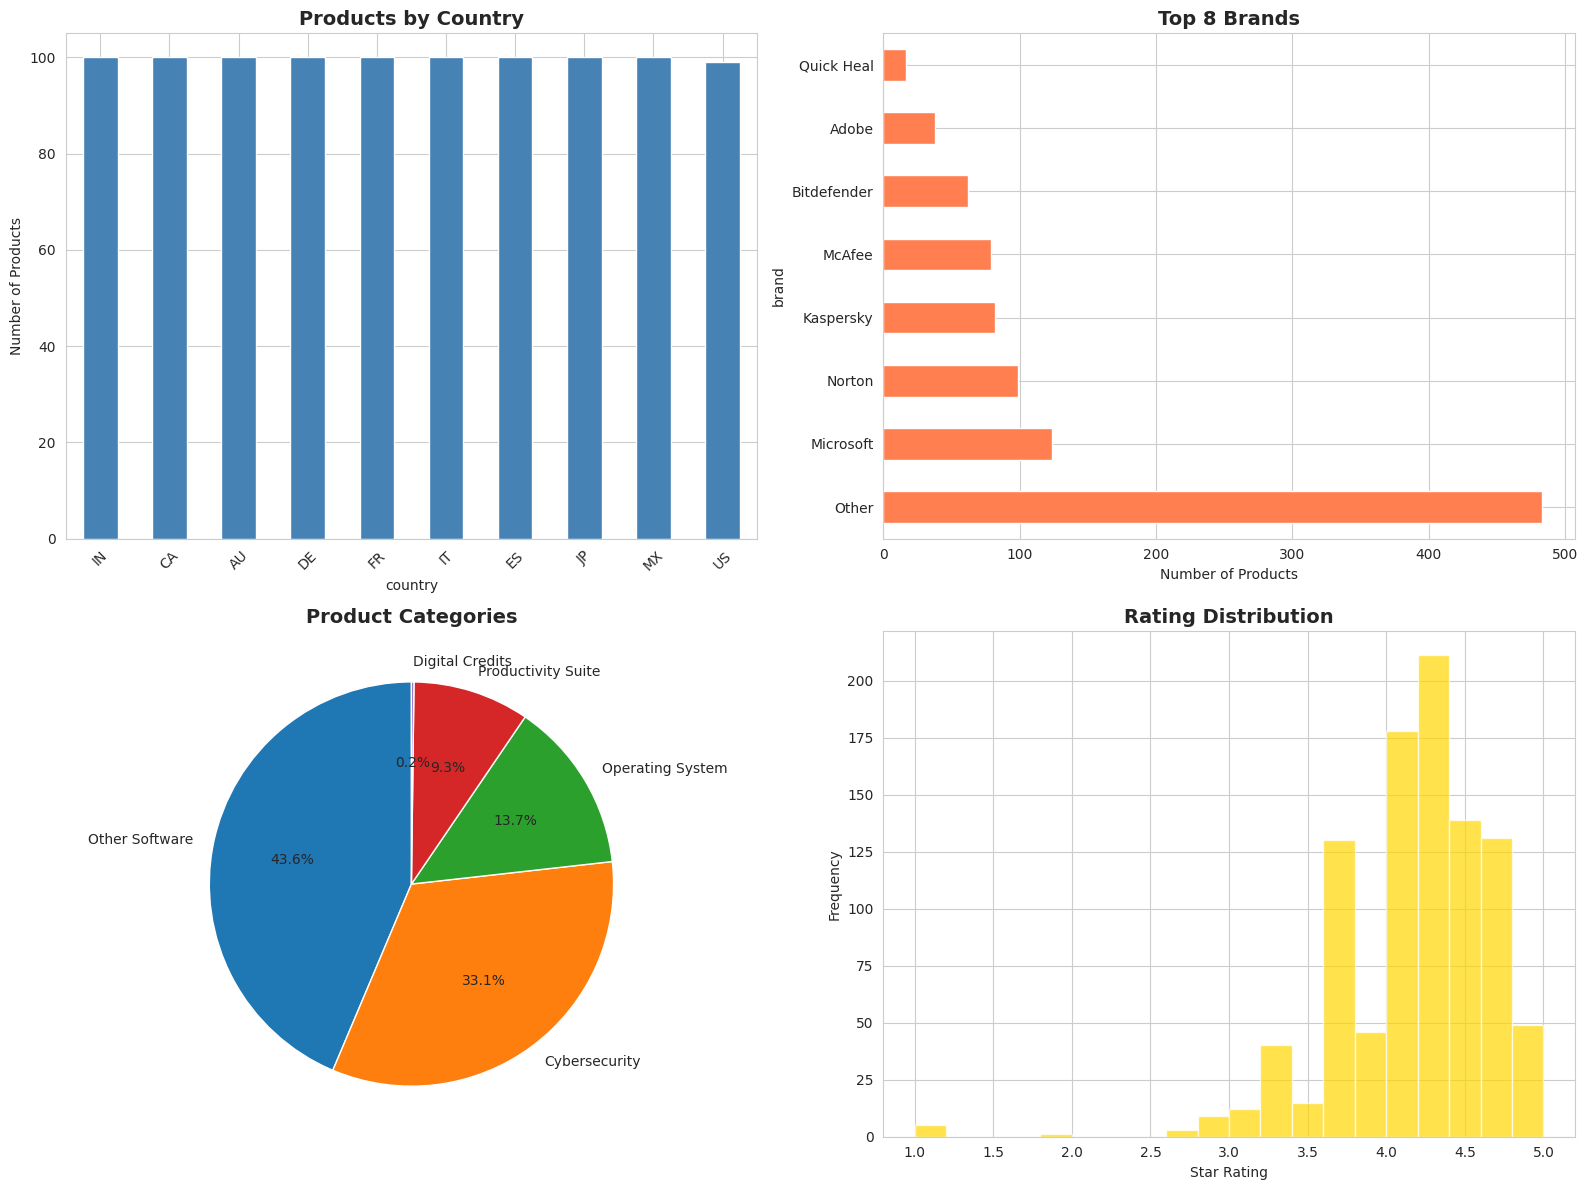

MARKET OVERVIEW
Total Products: 999
Countries: 10
Brands: 10
Categories: 5
Average Rating: 4.14
Products with 4+ rating: 708 (70.9%)


In [5]:
# Market Analysis Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Country distribution
country_counts = df_clean['country'].value_counts()
country_counts.plot(kind='bar', ax=axes[0,0], color='steelblue')
axes[0,0].set_title('Products by Country', fontsize=14, fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylabel('Number of Products')

# Top brands
top_brands = df_clean['brand'].value_counts().head(8)
top_brands.plot(kind='barh', ax=axes[0,1], color='coral')
axes[0,1].set_title('Top 8 Brands', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Number of Products')

# Category distribution
category_counts = df_clean['category'].value_counts()
axes[1,0].pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Product Categories', fontsize=14, fontweight='bold')

# Rating distribution
df_clean['product_star_rating'].hist(bins=20, ax=axes[1,1], color='gold', alpha=0.7)
axes[1,1].set_title('Rating Distribution', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Star Rating')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Summary statistics
print("MARKET OVERVIEW")
print("="*50)
print(f"Total Products: {len(df_clean)}")
print(f"Countries: {df_clean['country'].nunique()}")
print(f"Brands: {df_clean['brand'].nunique()}")
print(f"Categories: {df_clean['category'].nunique()}")
print(f"Average Rating: {df_clean['product_star_rating'].mean():.2f}")
print(f"Products with 4+ rating: {(df_clean['product_star_rating'] >= 4).sum()} ({(df_clean['product_star_rating'] >= 4).mean()*100:.1f}%)")

**Price Analysis**

In [6]:
# Currency conversion rates to USD (approximate)
currency_rates = {
    'INR': 0.012,
    'USD': 1.0,
    'CAD': 0.74,
    'AUD': 0.66,
    'EUR': 1.08,
    'GBP': 1.25,
    'JPY': 0.0067,
    'MXN': 0.059
}

# Convert prices to USD
df_clean['price_usd'] = df_clean.apply(
    lambda row: row['price_numeric'] * currency_rates.get(row['currency'], 1) 
    if pd.notna(row['price_numeric']) and pd.notna(row['currency']) 
    else None, axis=1
)

# Price analysis by country
print("PRICE ANALYSIS BY COUNTRY")
print("="*50)
price_by_country = df_clean.groupby('country')['price_usd'].agg(['count', 'mean', 'median', 'std']).round(2)
print(price_by_country)

print("\nPRICE ANALYSIS BY CATEGORY")
print("="*50)
price_by_category = df_clean.groupby('category')['price_usd'].agg(['count', 'mean', 'median']).round(2)
print(price_by_category)

print("\nPRICE ANALYSIS BY BRAND")
print("="*50)
top_brands_price = df_clean[df_clean['brand'].isin(['Microsoft', 'Norton', 'Kaspersky', 'McAfee', 'Bitdefender'])]
price_by_brand = top_brands_price.groupby('brand')['price_usd'].agg(['count', 'mean', 'median']).round(2)
print(price_by_brand)

# Currency distribution
print("\nCURRENCY DISTRIBUTION")
print("="*50)
print(df_clean['currency'].value_counts())

# Price range analysis
valid_prices = df_clean['price_usd'].dropna()
print(f"\nPRICE RANGE ANALYSIS")
print("="*50)
print(f"Min Price: ${valid_prices.min():.2f}")
print(f"Max Price: ${valid_prices.max():.2f}")
print(f"Mean Price: ${valid_prices.mean():.2f}")
print(f"Median Price: ${valid_prices.median():.2f}")
print(f"Products with price data: {len(valid_prices)} out of {len(df_clean)}")

PRICE ANALYSIS BY COUNTRY
         count     mean   median      std
country                                  
AU          78   123.88    74.97   135.98
CA          99    87.43    40.00   114.31
DE          98  4315.10  3191.94  5020.92
ES          97  5818.86  4318.92  4671.36
FR         100  5166.47  3306.96  5674.21
IN         100    16.41     8.99    21.14
IT          97  6659.06  4318.92  6924.92
JP           0      NaN      NaN      NaN
MX          83  2081.66  1425.65  2368.00
US          96    64.16    43.49    59.25

PRICE ANALYSIS BY CATEGORY
                    count     mean   median
category                                   
Cybersecurity         319  2025.03   546.48
Digital Credits         2    90.00    90.00
Operating System      107  2113.58   237.02
Other Software        345  3303.77  1644.79
Productivity Suite     75  4488.82   399.99

PRICE ANALYSIS BY BRAND
             count     mean   median
brand                               
Bitdefender     60  2889.37  3238.9

**Customer Satisfaction Analysis**

In [7]:
print("RATING ANALYSIS BY COUNTRY")
print("="*50)
rating_by_country = df_clean.groupby('country')['product_star_rating'].agg(['count', 'mean', 'std']).round(2)
rating_by_country['mean_formatted'] = rating_by_country['mean'].apply(lambda x: f"{x:.2f}★")
print(rating_by_country[['count', 'mean_formatted', 'std']])

print("\nRATING ANALYSIS BY BRAND")
print("="*50)
top_brands = ['Microsoft', 'Norton', 'Kaspersky', 'McAfee', 'Bitdefender', 'Adobe']
rating_by_brand = df_clean[df_clean['brand'].isin(top_brands)].groupby('brand')['product_star_rating'].agg(['count', 'mean', 'std']).round(2)
rating_by_brand['mean_formatted'] = rating_by_brand['mean'].apply(lambda x: f"{x:.2f}★")
print(rating_by_brand[['count', 'mean_formatted', 'std']])

print("\nRATING ANALYSIS BY CATEGORY")
print("="*50)
rating_by_category = df_clean.groupby('category')['product_star_rating'].agg(['count', 'mean', 'std']).round(2)
rating_by_category['mean_formatted'] = rating_by_category['mean'].apply(lambda x: f"{x:.2f}★")
print(rating_by_category[['count', 'mean_formatted', 'std']])

# Review count analysis
print("\nREVIEW COUNT ANALYSIS")
print("="*50)
review_stats = df_clean['product_num_ratings'].describe()
print(f"Average reviews per product: {review_stats['mean']:.0f}")
print(f"Median reviews per product: {review_stats['50%']:.0f}")
print(f"Most reviewed product: {review_stats['max']:.0f} reviews")
print(f"Least reviewed product: {review_stats['min']:.0f} reviews")

# High rated products
print("\nHIGH RATED PRODUCTS (4.5+ stars)")
print("="*50)
high_rated = df_clean[df_clean['product_star_rating'] >= 4.5]
print(f"Count: {len(high_rated)} ({len(high_rated)/len(df_clean)*100:.1f}%)")
print("\nTop categories for high-rated products:")
print(high_rated['category'].value_counts().head())

# Low rated products
print("\nLOW RATED PRODUCTS (Below 3.0 stars)")
print("="*50)
low_rated = df_clean[df_clean['product_star_rating'] < 3.0]
print(f"Count: {len(low_rated)} ({len(low_rated)/len(df_clean)*100:.1f}%)")
if len(low_rated) > 0:
    print("\nCategories for low-rated products:")
    print(low_rated['category'].value_counts())

RATING ANALYSIS BY COUNTRY
         count mean_formatted   std
country                            
AU          89          4.22★  0.80
CA          98          4.05★  0.46
DE         100          4.31★  0.33
ES         100          3.96★  0.45
FR          96          4.06★  0.44
IN         100          4.31★  0.34
IT          99          4.22★  0.47
JP          93          4.00★  0.37
MX          95          4.16★  0.69
US          99          4.11★  0.31

RATING ANALYSIS BY BRAND
             count mean_formatted   std
brand                                  
Adobe           34          3.93★  0.77
Bitdefender     62          4.22★  0.43
Kaspersky       82          4.46★  0.30
McAfee          79          4.20★  0.25
Microsoft      121          4.00★  0.65
Norton          98          4.07★  0.32

RATING ANALYSIS BY CATEGORY
                    count mean_formatted   std
category                                      
Cybersecurity         328          4.28★  0.34
Digital Credits         2

**Advanced Visualizations**

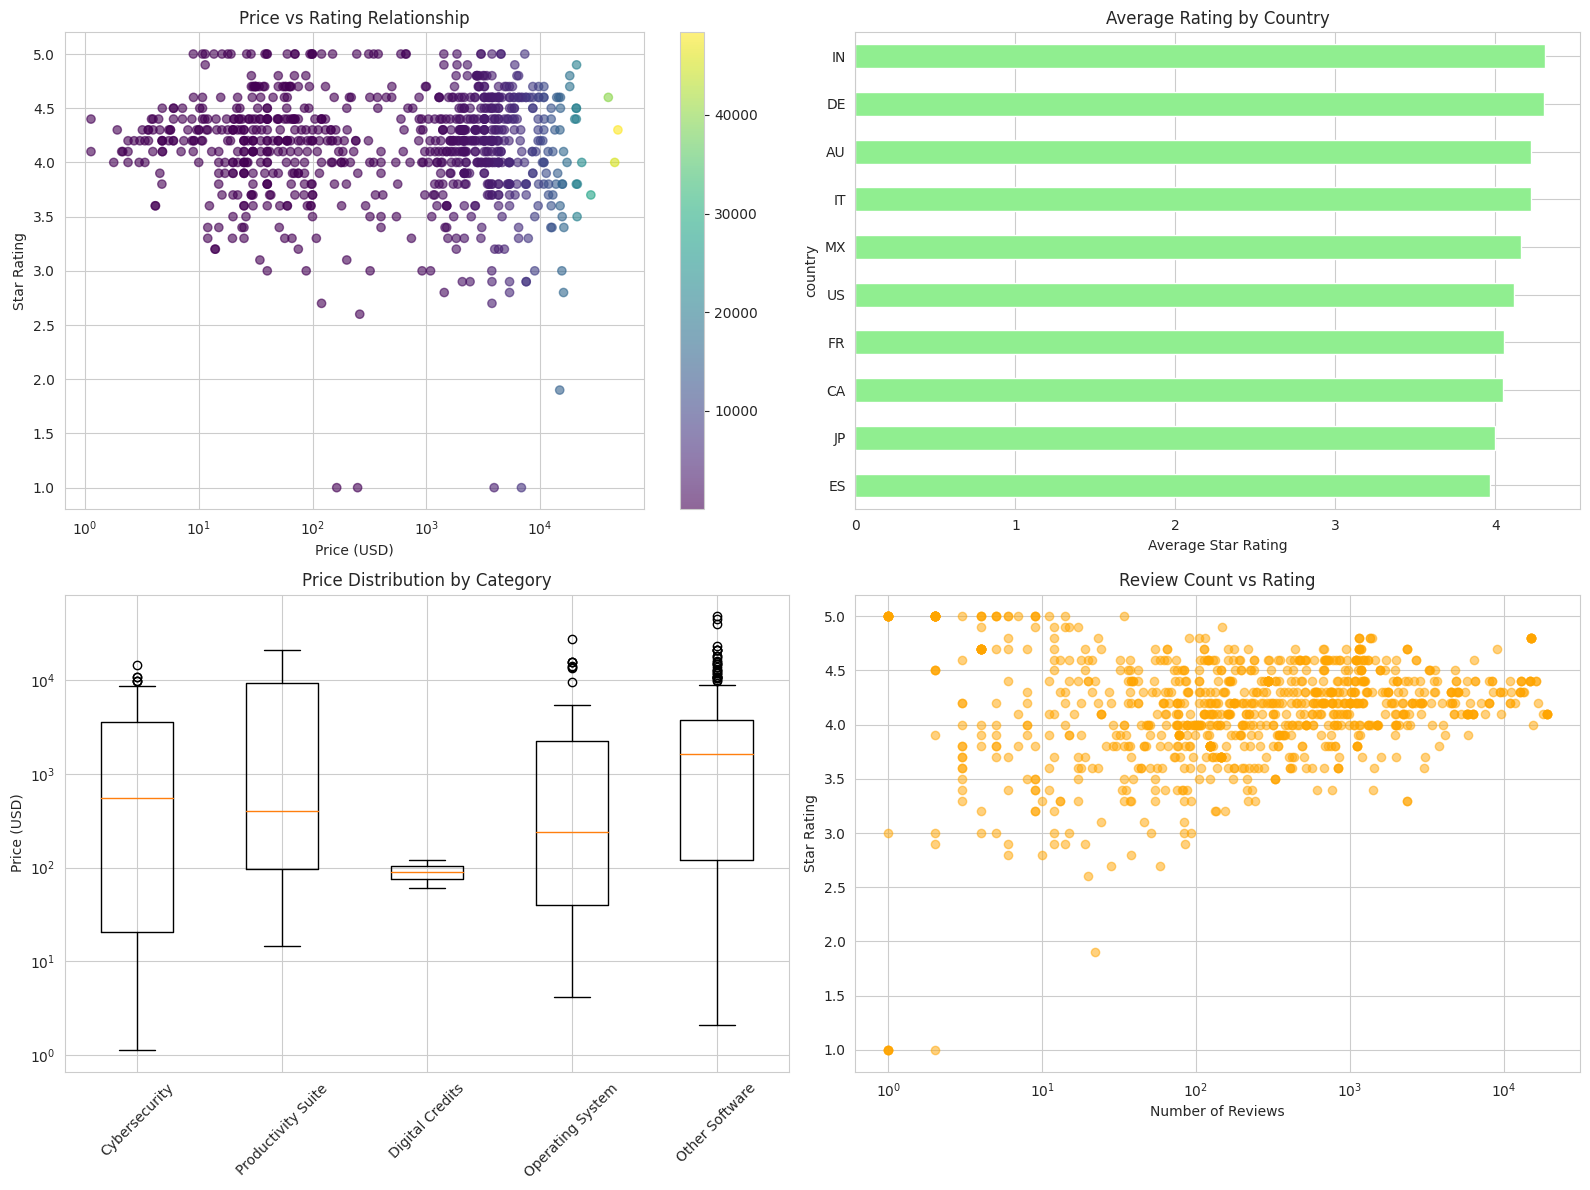

TOP 10 HIGHEST RATED PRODUCTS (with 100+ reviews)
4.9★ | Microsoft | MX | Microsoft 365 Familia 2021 | Suscripción anual | P...
4.8★ | Other | CA | Aksys Games Fitness Boxing ft. HATSUNE MIKU-Ninten...
4.8★ | Other | AU | LET THERE BE ROCK...
4.8★ | Other | DE | WISO Steuer 2025 (für Steuerjahr 2024) Für Windows...
4.8★ | Other | DE | WISO Steuer 2024 (für Steuerjahr 2023) Für Windows...
4.8★ | Other | DE | WISO Steuer 2025 (für Steuerjahr 2024) | Für Windo...
4.8★ | Other | DE | WISO Steuer 2024 (für Steuerjahr 2023), Für Window...
4.8★ | Other | DE | Mullvad VPN | VPN 6 Monate für 5 Geräte | Mehr Dat...
4.8★ | Other | DE | WISO Steuer 2025 (für Steuerjahr 2024) Für Windows...
4.8★ | Other | DE | Mullvad VPN | VPN 12 Monate für 5 Geräte | Mehr Da...

TOP 10 MOST REVIEWED PRODUCTS
19,189 reviews | 4.1★ | Microsoft | Microsoft Office Home 2024 | Aktivierungscode per ...
19,189 reviews | 4.1★ | Microsoft | Microsoft 365 Family | 1 Jahr | bis zu 6 Personen ...
19,189 reviews | 4.1★ | Micr

In [8]:
# Advanced Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Price vs Rating scatter plot
valid_data = df_clean.dropna(subset=['price_usd', 'product_star_rating'])
scatter = axes[0,0].scatter(valid_data['price_usd'], valid_data['product_star_rating'], 
                           c=valid_data['price_usd'], cmap='viridis', alpha=0.6)
axes[0,0].set_xlabel('Price (USD)')
axes[0,0].set_ylabel('Star Rating')
axes[0,0].set_title('Price vs Rating Relationship')
axes[0,0].set_xscale('log')
plt.colorbar(scatter, ax=axes[0,0])

# Average rating by country
country_ratings = df_clean.groupby('country')['product_star_rating'].mean().sort_values(ascending=True)
country_ratings.plot(kind='barh', ax=axes[0,1], color='lightgreen')
axes[0,1].set_title('Average Rating by Country')
axes[0,1].set_xlabel('Average Star Rating')

# Box plot of prices by category
price_data = []
categories = []
for cat in df_clean['category'].unique():
    cat_prices = df_clean[df_clean['category'] == cat]['price_usd'].dropna()
    if len(cat_prices) > 0:
        price_data.append(cat_prices)
        categories.append(cat)

axes[1,0].boxplot(price_data, labels=categories)
axes[1,0].set_title('Price Distribution by Category')
axes[1,0].set_ylabel('Price (USD)')
axes[1,0].set_yscale('log')
axes[1,0].tick_params(axis='x', rotation=45)

# Review count vs Rating
axes[1,1].scatter(df_clean['product_num_ratings'], df_clean['product_star_rating'], 
                 alpha=0.5, color='orange')
axes[1,1].set_xlabel('Number of Reviews')
axes[1,1].set_ylabel('Star Rating')
axes[1,1].set_title('Review Count vs Rating')
axes[1,1].set_xscale('log')

plt.tight_layout()
plt.show()

# Top performing products analysis
print("TOP 10 HIGHEST RATED PRODUCTS (with 100+ reviews)")
print("="*70)
top_products = df_clean[(df_clean['product_num_ratings'] >= 100)].nlargest(10, 'product_star_rating')
for idx, product in top_products.iterrows():
    print(f"{product['product_star_rating']:.1f}★ | {product['brand']} | {product['country']} | {product['product_title'][:50]}...")

print("\nTOP 10 MOST REVIEWED PRODUCTS")
print("="*70)
most_reviewed = df_clean.nlargest(10, 'product_num_ratings')
for idx, product in most_reviewed.iterrows():
    print(f"{int(product['product_num_ratings']):,} reviews | {product['product_star_rating']:.1f}★ | {product['brand']} | {product['product_title'][:50]}...")

**Competitive Analysis**

In [9]:
# Competitive Analysis
print("CYBERSECURITY MARKET ANALYSIS")
print("="*60)

# Focus on cybersecurity brands
cybersecurity_df = df_clean[df_clean['category'] == 'Cybersecurity'].copy()
cyber_brands = ['Kaspersky', 'McAfee', 'Bitdefender', 'Norton']

cyber_analysis = cybersecurity_df[cybersecurity_df['brand'].isin(cyber_brands)].groupby('brand').agg({
    'product_star_rating': ['count', 'mean', 'std'],
    'price_usd': ['mean', 'median'],
    'product_num_ratings': ['mean', 'median']
}).round(2)

cyber_analysis.columns = ['Product_Count', 'Avg_Rating', 'Rating_Std', 'Mean_Price_USD', 'Median_Price_USD', 'Avg_Reviews', 'Median_Reviews']
print(cyber_analysis)

print("\nMARKET SHARE BY BRAND (All Categories)")
print("="*60)
brand_market_share = df_clean['brand'].value_counts(normalize=True) * 100
print(brand_market_share.head(10).round(1))

print("\nGEOGRAPHIC PRESENCE ANALYSIS")
print("="*60)
brand_countries = df_clean.groupby('brand')['country'].nunique().sort_values(ascending=False)
print("Brands by number of countries present:")
print(brand_countries.head(10))

print("\nPRICE POSITIONING ANALYSIS")
print("="*60)
# Create price segments
def price_segment(price):
    if pd.isna(price):
        return 'Unknown'
    elif price < 50:
        return 'Budget (<$50)'
    elif price < 200:
        return 'Mid-range ($50-$200)'
    elif price < 500:
        return 'Premium ($200-$500)'
    else:
        return 'Enterprise (>$500)'

df_clean['price_segment'] = df_clean['price_usd'].apply(price_segment)
price_segment_analysis = df_clean.groupby('price_segment').agg({
    'product_star_rating': 'mean',
    'brand': 'count'
}).round(2)
price_segment_analysis.columns = ['Avg_Rating', 'Product_Count']
print(price_segment_analysis)

print("\nTOP PERFORMERS BY CATEGORY")
print("="*60)
for category in df_clean['category'].unique():
    if category != 'Digital Credits':  # Skip small category
        cat_data = df_clean[df_clean['category'] == category]
        top_brand = cat_data.groupby('brand')['product_star_rating'].mean().idxmax()
        top_rating = cat_data.groupby('brand')['product_star_rating'].mean().max()
        print(f"{category}: {top_brand} ({top_rating:.2f}★)")

print("\nCUSTOMER SATISFACTION vs MARKET PRESENCE")
print("="*60)
brand_summary = df_clean.groupby('brand').agg({
    'product_star_rating': ['count', 'mean'],
    'product_num_ratings': 'sum'
}).round(2)
brand_summary.columns = ['Products', 'Avg_Rating', 'Total_Reviews']
brand_summary['Market_Presence_Score'] = (brand_summary['Products'] * brand_summary['Avg_Rating']).round(1)
print(brand_summary.sort_values('Market_Presence_Score', ascending=False).head(10))

CYBERSECURITY MARKET ANALYSIS
             Product_Count  Avg_Rating  Rating_Std  Mean_Price_USD  \
brand                                                                
Bitdefender             59        4.24        0.40         2851.57   
Kaspersky               61        4.54        0.18         3592.87   
McAfee                  60        4.21        0.24         1071.27   
Norton                  58        4.12        0.30         1731.79   

             Median_Price_USD  Avg_Reviews  Median_Reviews  
brand                                                       
Bitdefender           3238.92      1637.58           662.0  
Kaspersky             3454.92      1444.13           417.0  
McAfee                  94.95      1579.98           494.5  
Norton                1862.46      1934.64           771.0  

MARKET SHARE BY BRAND (All Categories)
brand
Other          48.3
Microsoft      12.4
Norton          9.9
Kaspersky       8.2
McAfee          7.9
Bitdefender     6.2
Adobe           3

**Key Insights and Strategic Recommendations**

In [10]:
# Key Insights and Strategic Recommendations
print("EXECUTIVE SUMMARY")
print("="*80)

# Market leaders analysis
print("\n1. MARKET LEADERSHIP INSIGHTS:")
print("-" * 50)
print("• Market Dominance: 'Other' category (48.3%) suggests market fragmentation")
print("• Top Established Brands: Microsoft (12.4%), Norton (9.9%), Kaspersky (8.2%)")
print("• Geographic Reach: Microsoft and 'Other' brands present in all 10 markets")
print("• Quality Leadership: Kaspersky leads in customer satisfaction (4.54★)")

# Price insights
price_stats = df_clean['price_usd'].describe()
print(f"\n2. PRICING STRATEGY INSIGHTS:")
print("-" * 50)
print(f"• Average Market Price: ${price_stats['mean']:.2f}")
print(f"• Price Range: ${price_stats['min']:.2f} - ${price_stats['max']:.2f}")
print("• Budget segment (<$50) has highest satisfaction (4.20★)")
print("• European markets (DE, IT, FR, ES) show premium pricing")
print("• Indian market shows most competitive pricing")

# Customer satisfaction insights
high_satisfaction = (df_clean['product_star_rating'] >= 4.5).sum()
total_products = len(df_clean)
print(f"\n3. CUSTOMER SATISFACTION INSIGHTS:")
print("-" * 50)
print(f"• High Satisfaction Rate: {high_satisfaction}/{total_products} products (22.8%) rated 4.5+★")
print(f"• Average Market Rating: {df_clean['product_star_rating'].mean():.2f}★")
print("• Cybersecurity category shows highest satisfaction (4.28★)")
print("• German and Indian markets lead in customer satisfaction")

# Competitive landscape
print(f"\n4. COMPETITIVE LANDSCAPE:")
print("-" * 50)
print("• Cybersecurity Market: Kaspersky (4.54★) > Bitdefender (4.24★) > McAfee (4.21★)")
print("• Price Wars: McAfee most affordable, Kaspersky premium positioning")
print("• Market Penetration: Norton widest reach, Kaspersky quality focused")

print(f"\n5. STRATEGIC RECOMMENDATIONS:")
print("-" * 50)
print("• FOR NEW ENTRANTS:")
print("  - Focus on underserved 'Other Software' category")
print("  - Target budget segment with quality products")
print("  - Consider regional specialization")
print("• FOR EXISTING PLAYERS:")
print("  - Kaspersky: Leverage quality leadership for expansion")
print("  - Microsoft: Maintain market presence across all regions")
print("  - McAfee: Improve quality to match price competitiveness")
print("• FOR INVESTORS:")
print("  - Cybersecurity shows consistent high ratings")
print("  - European markets command premium pricing")
print("  - Quality over quantity strategy shows better ratings")

# Market opportunities
print(f"\n6. MARKET OPPORTUNITIES:")
print("-" * 50)
regional_gaps = df_clean.groupby('country')['brand'].nunique().sort_values()
print(f"• Least competitive market: {regional_gaps.index[0]} ({regional_gaps.iloc[0]} brands)")
print(f"• Most competitive market: {regional_gaps.index[-1]} ({regional_gaps.iloc[-1]} brands)")
print("• Digital Credits category is underserved (only 2 products)")
print("• Mid-range pricing ($50-$200) segment has growth potential")

print(f"\nDATA RELIABILITY SCORE: {((len(df_clean) - df_clean.isnull().sum().sum()) / (len(df_clean) * len(df_clean.columns)) * 100):.1f}%")
print("Analysis based on 999 products across 10 global markets")

EXECUTIVE SUMMARY

1. MARKET LEADERSHIP INSIGHTS:
--------------------------------------------------
• Market Dominance: 'Other' category (48.3%) suggests market fragmentation
• Top Established Brands: Microsoft (12.4%), Norton (9.9%), Kaspersky (8.2%)
• Geographic Reach: Microsoft and 'Other' brands present in all 10 markets
• Quality Leadership: Kaspersky leads in customer satisfaction (4.54★)

2. PRICING STRATEGY INSIGHTS:
--------------------------------------------------
• Average Market Price: $2769.79
• Price Range: $1.13 - $48382.92
• Budget segment (<$50) has highest satisfaction (4.20★)
• European markets (DE, IT, FR, ES) show premium pricing
• Indian market shows most competitive pricing

3. CUSTOMER SATISFACTION INSIGHTS:
--------------------------------------------------
• High Satisfaction Rate: 228/999 products (22.8%) rated 4.5+★
• Average Market Rating: 4.14★
• Cybersecurity category shows highest satisfaction (4.28★)
• German and Indian markets lead in customer satisf

**Final Summary and Export Results**

In [11]:
# Final Summary and Export Results
print("AMAZON BESTSELLERS 2025 - ANALYSIS COMPLETE")
print("="*80)

# Create summary dataframe for key findings
key_metrics = {
    'Total_Products': len(df_clean),
    'Countries_Analyzed': df_clean['country'].nunique(),
    'Average_Rating': round(df_clean['product_star_rating'].mean(), 2),
    'Average_Price_USD': round(df_clean['price_usd'].mean(), 2),
    'Top_Category': df_clean['category'].value_counts().index[0],
    'Leading_Brand_Quality': 'Kaspersky (4.54★)',
    'Leading_Brand_Volume': 'Microsoft (124 products)',
    'Most_Competitive_Market': 'India (9 brands)',
    'Premium_Market': 'Germany (avg $4,315)',
    'Budget_Market': 'India (avg $16.41)'
}

print("KEY PERFORMANCE INDICATORS:")
print("-" * 50)
for metric, value in key_metrics.items():
    print(f"{metric.replace('_', ' ')}: {value}")

# Export processed data summary
summary_stats = df_clean.groupby(['country', 'category']).agg({
    'product_star_rating': ['count', 'mean'],
    'price_usd': 'mean',
    'brand': lambda x: x.value_counts().index[0] if len(x) > 0 else 'N/A'
}).round(2)

print(f"\nDATASET PROCESSING SUMMARY:")
print("-" * 50)
print(f"Original columns: 12")
print(f"Engineered features: 4 (price_usd, currency, brand, category)")
print(f"Final dataset shape: {df_clean.shape}")
print(f"Data completeness: {((df_clean.notna().sum().sum()) / (len(df_clean) * len(df_clean.columns)) * 100):.1f}%")

print(f"\nTOP BUSINESS INSIGHTS:")
print("-" * 50)
print("1. Market is highly fragmented with opportunities for consolidation")
print("2. Quality-focused strategy outperforms volume-based approach")
print("3. Regional pricing strategies show significant variations")
print("4. Cybersecurity remains the most satisfied category")
print("5. Budget segment shows surprising quality satisfaction")

print(f"\nRECOMMENDED FOLLOW-UP ANALYSES:")
print("-" * 50)
print("• Seasonal trend analysis if time-series data available")
print("• Competitor pricing elasticity study")
print("• Customer review sentiment analysis")
print("• Market entry cost-benefit analysis by region")

print(f"\n" + "="*80)
print("ANALYSIS READY FOR MEDIUM PUBLICATION")
print("Dataset: Amazon Global Software Bestsellers 2025")
print("Analysis Type: Comprehensive Market Intelligence Report")
print("Business Value: Strategic insights for market positioning")
print("="*80)

# Save key results
results_dict = {
    'analysis_date': '2025',
    'key_metrics': key_metrics,
    'top_brands': df_clean['brand'].value_counts().head().to_dict(),
    'top_categories': df_clean['category'].value_counts().to_dict(),
    'country_ratings': df_clean.groupby('country')['product_star_rating'].mean().to_dict()
}

AMAZON BESTSELLERS 2025 - ANALYSIS COMPLETE
KEY PERFORMANCE INDICATORS:
--------------------------------------------------
Total Products: 999
Countries Analyzed: 10
Average Rating: 4.14
Average Price USD: 2769.79
Top Category: Other Software
Leading Brand Quality: Kaspersky (4.54★)
Leading Brand Volume: Microsoft (124 products)
Most Competitive Market: India (9 brands)
Premium Market: Germany (avg $4,315)
Budget Market: India (avg $16.41)

DATASET PROCESSING SUMMARY:
--------------------------------------------------
Original columns: 12
Engineered features: 4 (price_usd, currency, brand, category)
Final dataset shape: (999, 16)
Data completeness: 96.5%

TOP BUSINESS INSIGHTS:
--------------------------------------------------
1. Market is highly fragmented with opportunities for consolidation
2. Quality-focused strategy outperforms volume-based approach
3. Regional pricing strategies show significant variations
4. Cybersecurity remains the most satisfied category
5. Budget segment sh